### Import Libraries

Import necessary libraries

In [1]:
import glob
import os
import librosa
import librosa.display
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import noisereduce as nr
import matplotlib.pyplot as plt
from matplotlib import cm
import skimage.io
import re
import pathlib
from IPython.display import display, Image
# %matplotlib inline
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from pydub.effects import normalize

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

2022-09-11 21:12:37.418032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-11 21:12:37.418062: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
RATE = 16000
TOP_DB = 25
HOP_LEGTH = 512
FRAME_SIZE = 2048
DPI = 96

# Preprocess steps
1. Load audio file
2. Trim leading and trailing silence
3. Noise reduction
4. Normalize

In [3]:

def audiosegment_to_librosawav(audiosegment):    
    channel_sounds = audiosegment.split_to_mono()
    samples = [s.get_array_of_samples() for s in channel_sounds]

    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(samples[0].typecode).max
    fp_arr = fp_arr.reshape(-1)

    return fp_arr


def librosa_to_audiosegment(filename):
    y, sr = librosa.load(filename, sr=RATE)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB) # trim leading and trailing silence
    y = nr.reduce_noise(y, sr=sr) # noise reduction
    # convert from float to uint16
    y = np.array(y * (1<<15), dtype=np.int16)
    audio_segment = AudioSegment(
        y.tobytes(), 
        frame_rate=sr,
        sample_width=y.dtype.itemsize, 
        channels=1
    )
    return audio_segment

def preprocess(filename):
    audio = librosa_to_audiosegment(filename)
    audio = normalize(audio)
    audio = audiosegment_to_librosawav(audio)
    return audio


In [4]:
def stft(data):
    data = np.abs(librosa.stft(data, hop_length=HOP_LEGTH, n_fft=FRAME_SIZE))
    return librosa.power_to_db(data, ref=np.max)

def chroma(data):
    data = stft(data)
    return librosa.feature.chroma_stft(S=stft, sr=RATE)

def mel(data):
    mels = librosa.feature.melspectrogram(y=data, sr=RATE)
    return librosa.power_to_db(mels, ref=np.max)

def mfcc(data):
    return librosa.feature.mfcc(y=data, sr=RATE, n_fft=FRAME_SIZE, hop_length=HOP_LEGTH)

In [5]:
def create_images_from_feature(df: pd.DataFrame, op, dim):

    _fig, ax = plt.subplots(1, figsize=(dim, dim))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # audio = preprocess(row['File_Path'])
        try:
            audio, sr = librosa.load(row['File_Path'], sr=RATE)
            audio, _ = librosa.effects.trim(audio, top_db=TOP_DB)
            # audio = nr.reduce_noise(audio, sr=sr)
            data = mel(audio)
            emo = row['Emotion']
        except:
            print('Skipped:', row['File_Path'])
            continue

        image = librosa.display.specshow(data, ax=ax, sr=RATE, y_axis='linear')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        plt.jet()
        _fig.savefig(f'{op}/{emo}-{i}.png')
        plt.cla()
    plt.close(_fig)
    plt.close("all")

# Building Dataframe

In [6]:
Crema_Path='../Datasets/Crema/'
Ravdess_Path='../Datasets/Ravdess/'
Savee_Path='../Datasets/Savee/'
Tess_Path='../Datasets/Tess/'

In [7]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav


In [8]:
ravdess=[]
for directory in os.listdir(Ravdess_Path):
    actors=os.listdir(os.path.join(Ravdess_Path,directory))
    for wav in actors:
        emotion=wav.partition('.wav')[0].split('-')
        emotion_number=int(emotion[2])
        ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
Ravdess_df=pd.DataFrame.from_dict(ravdess)
Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Ravdess_df['Emotion'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'},inplace=True)
Ravdess_df.head()

,Emotion,File_Path
0,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-01-01...
1,sad,../Datasets/Ravdess/Actor_08/03-01-04-02-02-02...
2,neutral,../Datasets/Ravdess/Actor_08/03-01-02-01-02-01...
3,happy,../Datasets/Ravdess/Actor_08/03-01-03-01-02-01...
4,fear,../Datasets/Ravdess/Actor_08/03-01-06-01-02-02...


In [9]:
savee=[]
for wav in os.listdir(Savee_Path):
    emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
    emotion=re.split(r'[0-9]',emo)[0]
    if emotion=='a':
        savee.append(('angry',Savee_Path+'/'+wav))
    elif emotion=='d':
        savee.append(('disgust',Savee_Path+'/'+wav))
    elif emotion=='f':
        savee.append(('fear',Savee_Path+'/'+wav))
    elif emotion=='h':
        savee.append(('happy',Savee_Path+'/'+wav))
    elif emotion=='n':
        savee.append(('neutral',Savee_Path+'/'+wav))
    elif emotion=='sa':
        savee.append(('sad',Savee_Path+'/'+wav))
    elif emotion=='su':
        savee.append(('surprise',Savee_Path+'/'+wav))
Savee_df=pd.DataFrame.from_dict(savee)
Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Savee_df.head()

,Emotion,File_Path
0,fear,../Datasets/Savee//KL_f05.wav
1,disgust,../Datasets/Savee//KL_d11.wav
2,neutral,../Datasets/Savee//DC_n06.wav
3,disgust,../Datasets/Savee//DC_d06.wav
4,surprise,../Datasets/Savee//DC_su06.wav


In [10]:
tess=[]
for directory in os.listdir(Tess_Path):
    for wav in os.listdir(os.path.join(Tess_Path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(Tess_Path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
Tess_df=pd.DataFrame.from_dict(tess)
Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Tess_df.head()

,Emotion,File_Path
0,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_dab...
1,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_mak...
2,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_bea...
3,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_hal...
4,surprise,../Datasets/Tess/OAF_Pleasant_surprise/OAF_pas...


In [11]:
main_df=pd.concat([Crema_df,Ravdess_df,Savee_df,Tess_df],axis=0)
main_df.shape

(12162, 2)

In [12]:
main_df.head(15)

,Emotion,File_Path
0,angry,../Datasets/Crema//1072_IOM_ANG_XX.wav
1,fear,../Datasets/Crema//1048_IOM_FEA_XX.wav
2,angry,../Datasets/Crema//1073_IEO_ANG_LO.wav
3,happy,../Datasets/Crema//1012_WSI_HAP_XX.wav
4,happy,../Datasets/Crema//1073_TSI_HAP_XX.wav
5,happy,../Datasets/Crema//1089_TSI_HAP_XX.wav
6,disgust,../Datasets/Crema//1031_MTI_DIS_XX.wav
7,disgust,../Datasets/Crema//1037_ITH_DIS_XX.wav
8,sad,../Datasets/Crema//1075_IEO_SAD_HI.wav
9,disgust,../Datasets/Crema//1051_MTI_DIS_XX.wav


In [13]:
main_df = main_df[main_df['Emotion'] != 'surprise']

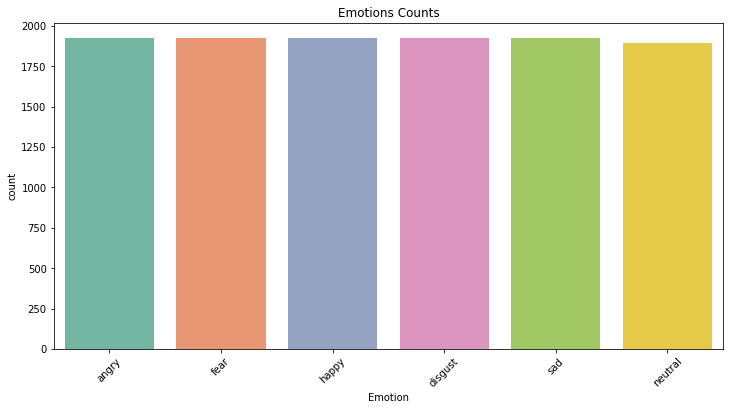

In [14]:
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette='Set2')
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
plt.show()

# Generating Images

In [19]:
dim = 3
feature_folder = f'./features/images/mel_trim_{dim*72}x{dim*72}'
pathlib.Path(feature_folder).mkdir(parents=False, exist_ok=True) 
create_images_from_feature(main_df, feature_folder, dim)

100%|██████████| 11510/11510 [15:15<00:00, 12.58it/s]


In [51]:
prin('...')

NameError: name 'prin' is not defined

## Shuffling data#reindexing to shuffle the data at random

In [ ]:
#reindexing to shuffle the data at random
df = df.reindex(np.random.permutation(df.index))
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head

In [ ]:
len(df)

## Splitting Dataset

In [ ]:
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produces test split.
remaining, test = train_test_split(
    df, test_size=ratio_test, stratify=df['label'])

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
train, val = train_test_split(
    remaining, test_size=ratio_val_adjusted, stratify=remaining['label'])

In [ ]:
train['label'].value_counts()

In [ ]:
val['label'].value_counts()

In [ ]:
test['label'].value_counts()

In [ ]:
import PIL

image = PIL.Image.open(df['image'][2])

width, height = image.size

print(width, height)
display(image)